In [1]:
## Calibrating Camera

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

nx = 9 # points in x direction
ny = 6 # points in y direction

cal_images = glob.glob('camera_cal/calibration*.jpg')

objpoints = []
imgpoints = []

objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

i = 0
I = []
for fname in cal_images:
    # read in each image
    img = cv2.imread(fname)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
    #If corners are found, add object points image points
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        i = i + 1
    else:
    # Record unrecognized images
        i = i + 1
        I.append(i)
        print(i)


10
19
20


In [2]:
## Undistortion function

def cal_undistort(img, objpoints, imgpoints):
    
    test_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, test_gray.shape[::-1],None,None)
    undist = cv2.undistort(img, mtx, dist)
    
    return undist


In [3]:
## Color and Sobel Threshold 

def pipeline(img, s_thresh=(90, 255),r_thresh=(150, 255), sx_thresh=(20, 100), sy_thresh=(65, 100) ):
    
    #s_thresh=(170, 255),r_thresh=(150, 255), sx_thresh=(20, 100), sy_thresh=(50, 100)
    img = np.copy(img)

    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Sobel y
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1) # Take the derivative in x
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    # Threshold x gradient
    sybinary = np.zeros_like(scaled_sobel)
    sybinary[(scaled_sobel >= sy_thresh[0]) & (scaled_sobel <= sy_thresh[1])] = 1
        
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # R channel
    
    r_channel = img[:, :, 0]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    
    # Combine each channel
    
    combined_binary = np.zeros_like(sxbinary)
    
    combined_binary[((r_binary == 1 ) & (s_binary == 1)) | ((sxbinary == 1) & (sybinary == 1))] = 1

    
    return combined_binary


In [4]:
## Perspective Transform

def transform(img):
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[199, 720], [594, 450], [689, 450], [1114, 720]])
    dst = np.float32([[320, 720], [320, 0], [960, 0], [960, 720]]) 
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Inverse perspective transform matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    top_down = cv2.warpPerspective(img, M, img_size)
    
    return top_down, M, Minv, img_size
    


In [5]:
# find_lane_pixels

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    #histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,binary_warped.shape[1]//6:binary_warped.shape[1]//6*5], axis=0)
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    return leftx, lefty, rightx, righty, ploty, out_img



In [6]:
def fit_polynomial(leftx, lefty, rightx, righty, ploty, out_img):

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    error = 0

    # Generate x and y values for plotting
    #ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        error = 1

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img, left_fitx, right_fitx, ploty, error


In [7]:
def measure_curv(leftx, lefty, rightx, righty, ploty, image_size):
    
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    leftx_r = leftx * xm_per_pix
    rightx_r = rightx * xm_per_pix
    lefty_r = lefty * ym_per_pix
    righty_r = righty * ym_per_pix
    
    left_fit_cr = np.polyfit(lefty_r, leftx_r, 2)
    right_fit_cr = np.polyfit(righty_r, rightx_r, 2)
    
    ploty_r = ploty * ym_per_pix
    y_eval = np.max(ploty_r)
    
    left_curverad = (1 + (2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**(3/2.0)/(2*np.absolute(left_fit_cr[0]))
    
    ## Implement the calculation of the left line here
    
    right_curverad = (1 + (2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**(3/2.0)/(2*np.absolute(right_fit_cr[0])) 
    
    ## Implement the calculation of the right line here
    
    left_curverad = round(left_curverad) / 1000

    right_curverad = round(right_curverad) / 1000
    
    left_pos = left_fit_cr[0]*(y_eval**2) + left_fit_cr[1]*y_eval + left_fit_cr[2]
    
    right_pos = right_fit_cr[0]*(y_eval**2) + right_fit_cr[1]*y_eval + right_fit_cr[2]
    
    road_center = (left_pos + right_pos) / 2
    
    image_center = image_size[0] * xm_per_pix / 2
    
    offset = image_center - road_center
    
    return left_curverad, right_curverad, offset, left_fit_cr, right_fit_cr



In [8]:
## Draw areas, display curvature and offset

def display(undist, top_down, ploty, left_fitx, right_fitx, img_size, left_curverad, right_curverad, offet):
    warp_zero = np.zeros_like(top_down).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, img_size) 
    # Combine the result with the original image
    comb_result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #plt.imshow(comb_result)
    font = cv2.FONT_HERSHEY_SIMPLEX

    TL = " Left curvature is " + str('%.3f' % round(left_curverad,3)) + ' ' + 'Km'

    TR = " Right curvature is " + str('%.3f' % round(right_curverad,3)) + ' ' + 'Km'

    TO = " Vehicle is off center " + str('%.2f' % round(offset,2)) + ' ' + 'm'


    cv2.putText(comb_result, TL ,(100,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(comb_result, TR ,(740,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(comb_result, TO ,(400,150), font, 1,(255,255,255),2,cv2.LINE_AA)

    #comb_result_R = cv2.cvtColor(comb_result, cv2.COLOR_BGR2RGB)
    #cv2.imwrite(r'output_images/test6_curve_offset.jpg',comb_result_R)
    #plt.imshow(comb_result)
    
    return comb_result



In [9]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = []     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = [] 
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = [] 
        #distance in meters of vehicle center from the line
        self.line_base_pos = [] 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = []  
        #y values for detected line pixels
        self.ally = []  


In [10]:

image = mpimg.imread('test_images/test2.jpg')

undist = cal_undistort(image, objpoints, imgpoints)

image_thresh = pipeline(undist)

image_top_down, M, Minv, img_size = transform(image_thresh)

leftx, lefty, rightx, righty, ploty, out_img = find_lane_pixels(image_top_down)

image_poly, left_fitx, right_fitx, ploty, error = fit_polynomial(leftx, lefty, rightx, righty, ploty, out_img)

left_curverad, right_curverad, offset, left_fit_cr, right_fit_cr = measure_curv(leftx, lefty, rightx, righty, ploty, img_size)

comb_result = display(undist, image_top_down, ploty, left_fitx, right_fitx, img_size, left_curverad, right_curverad, offset)

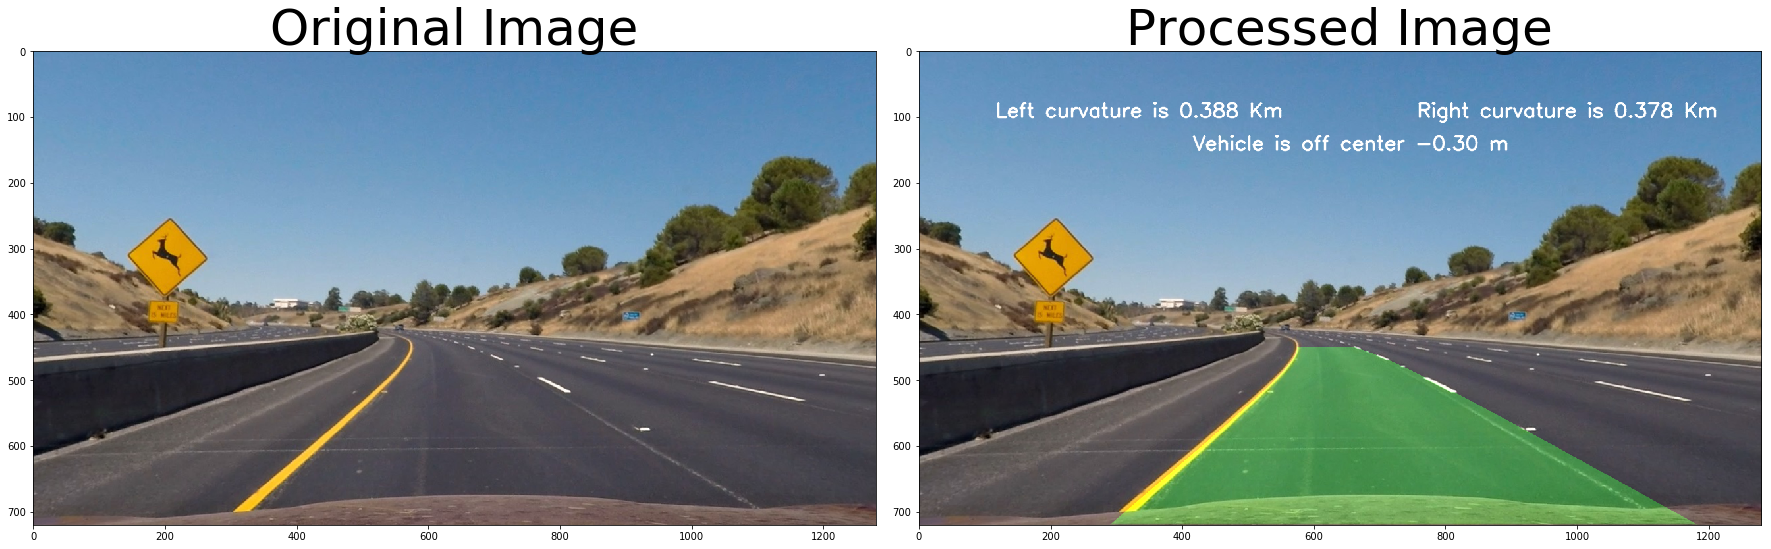

In [11]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(comb_result)
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
left = Line()
right = Line()
 

In [14]:
def process_image(image):
    undist = cal_undistort(image, objpoints, imgpoints)

    image_thresh = pipeline(undist)

    image_top_down, M, Minv, img_size = transform(image_thresh)

    leftx, lefty, rightx, righty, ploty, out_img = find_lane_pixels(image_top_down)

    image_poly, left_fitx, right_fitx, ploty, error = fit_polynomial(leftx, lefty, rightx, righty, ploty, out_img)

    left_curverad, right_curverad, offset, left_fit_cr, right_fit_cr = measure_curv(leftx, lefty, rightx, righty, ploty, img_size)

    comb_result = display(undist, image_top_down, ploty, left_fitx, right_fitx, img_size, left_curverad, right_curverad, offset)
    
    if (error == 1):
        left.detected = False
    else:
        left.detected = True
        left.recent_xfitted.append(left_fitx)
        left.bestx = np.mean(left.recent_xfitted[-1:-5], axis=0)
        
        left.best_fit.append(left_fit_cr)
        left.current_fit = left_fit_cr
        
        left.radius_of_curvature.append(left_curverad)
        left.line_base_pos.append(offset)
        
        left.diffs = left.current_fit - left.best_fit[-1]
        left.allx.append(leftx)
        left.ally.append(lefty)
        
    if (error == 1):
        right.detected = False
    else:
        right.detected = True
        right.recent_xfitted.append(left_fitx)
        right.bestx = np.mean(left.recent_xfitted[-1:-5], axis=0)
        
        right.best_fit.append(left_fit_cr)
        right.current_fit = left_fit_cr
        
        right.radius_of_curvature.append(left_curverad)
        right.line_base_pos.append(offset)
        
        right.diffs = left.current_fit - left.best_fit[-1]
        right.allx.append(leftx)
        right.ally.append(lefty)
    
    return comb_result

In [15]:
project_video_output = 'test_video_output/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

#clip1 = VideoFileClip("project_video.mp4").subclip(0,25)
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video test_video_output/project_video_output.mp4
[MoviePy] Writing video test_video_output/project_video_output.mp4


100%|█████████▉| 1260/1261 [11:35<00:00,  1.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/project_video_output.mp4 

CPU times: user 8min 40s, sys: 45.2 s, total: 9min 25s
Wall time: 11min 38s


In [16]:
project_video_output = 'test_video_output/project_video_output.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

In [17]:
challenge_output = 'test_video_output/challenge_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

#clip2 = VideoFileClip('challenge_video.mp4').subclip(0,5)
clip2 = VideoFileClip('challenge_video.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_video_output/challenge_output.mp4
[MoviePy] Writing video test_video_output/challenge_output.mp4


100%|██████████| 485/485 [04:20<00:00,  1.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/challenge_output.mp4 

CPU times: user 3min 15s, sys: 17.8 s, total: 3min 33s
Wall time: 4min 23s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [20]:
harder_challenge_output = 'test_video_output/Harder_challenge_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

clip3 = VideoFileClip('harder_challenge_video.mp4').subclip(0,5)
#clip3 = VideoFileClip('harder_challenge_video.mp4')
harder_challenge_clip = clip3.fl_image(process_image)
%time harder_challenge_clip.write_videofile(harder_challenge_output, audio=False)

[MoviePy] >>>> Building video test_video_output/Harder_challenge_output.mp4
[MoviePy] Writing video test_video_output/Harder_challenge_output.mp4



 99%|█████████▉| 125/126 [01:09<00:00,  1.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output/Harder_challenge_output.mp4 

CPU times: user 53.6 s, sys: 3.31 s, total: 56.9 s
Wall time: 1min 13s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_output))